# Importar Librerias.

In [82]:
!pip install lightgbm optuna

In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import optuna

# Carga de datos.

In [84]:
path = "/content/drive/MyDrive/Colab Notebooks/DB/retail_sales_dataset.csv"
df = pd.read_csv(path)

In [85]:
# Primera vista.
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


# EDA.

#Primera vista al Data Frame

In [86]:
# Se revisan las columnas y tipos de datos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


No se identifican valores Null.

#Limpieza de columnas

In [87]:
# Pasa todas las columnas a minusculas.
df.columns = df.columns.str.lower()

In [88]:
# Diccionario de caracteres que quiero reemplazar en los nombres de columnas.
# Aunque no se visualizan tildes, parentesis o ° se mantiene en el diccionario.
reemplazar = {
    "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u",
    " ":"_","(":"",")":"","°":"",".":""
    }

In [89]:
# Se recorre el diccionario de caracteres a reemplazar y se aplica en las columnas
for actual, nuevo in reemplazar.items():
  df.columns = df.columns.str.replace(actual,nuevo)

In [90]:
# Se verifican los cambios.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_id    1000 non-null   int64 
 1   date              1000 non-null   object
 2   customer_id       1000 non-null   object
 3   gender            1000 non-null   object
 4   age               1000 non-null   int64 
 5   product_category  1000 non-null   object
 6   quantity          1000 non-null   int64 
 7   price_per_unit    1000 non-null   int64 
 8   total_amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


* Verificacion de duplicados.

In [91]:
df.duplicated().sum()
# no se encuentran datos duplicados.

np.int64(0)

## Clasifica los datos:
* Crea una columna que clasifique las ventas en categorías significativas (e.g., ‘Alta’, ‘Media’, ‘Baja’).

In [92]:
# Funcion para clasifivar venta segun Total Venta.
def venta_tipo(total):
  if total <= 200:
    return 'Baja'
  elif total <= 300:
    return 'Media'
  else:
    return 'Alta'

In [93]:
# Mediante apply se verifica la clasificacion de la venta.
df["clasificacion"] = df["total_amount"].apply(venta_tipo)

In [94]:
# Verifica la columna creada.
df.head()

,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount,clasificacion
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,Baja
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,Alta
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,Baja
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,Alta
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,Baja


* Convierte la columna date a fecha.


In [95]:
# Se conviete date a formato fecha.
df['date'] = pd.to_datetime(df['date'])

In [96]:
# Separa la fecha en diferentes variables.
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [97]:
# veificar cambios.
df.head()

,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount,clasificacion,year,month,day
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,Baja,2023,11,24
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,Alta,2023,2,27
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,Baja,2023,1,13
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,Alta,2023,5,21
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,Baja,2023,5,6


In [98]:
# Eliminar columasn que no se usaran en el modelo.
df.drop(columns=["transaction_id","date","customer_id"], inplace=True)

In [99]:
df.head()

,gender,age,product_category,quantity,price_per_unit,total_amount,clasificacion,year,month,day
0,Male,34,Beauty,3,50,150,Baja,2023,11,24
1,Female,26,Clothing,2,500,1000,Alta,2023,2,27
2,Male,50,Electronics,1,30,30,Baja,2023,1,13
3,Male,37,Clothing,1,500,500,Alta,2023,5,21
4,Male,30,Beauty,2,50,100,Baja,2023,5,6


# Revision de datos.

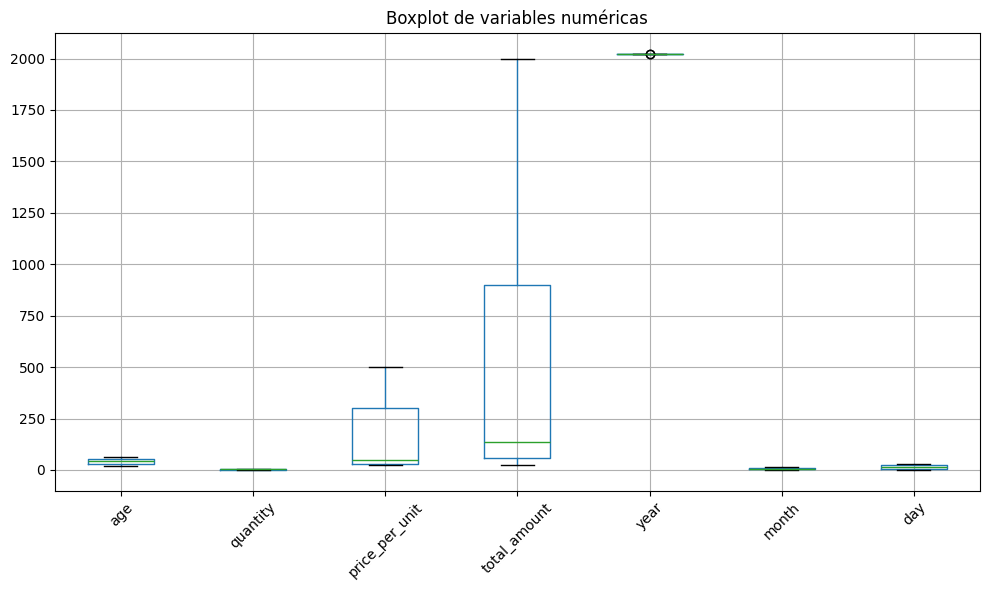

In [100]:
# Crear boxplot para una revision mas sencilla a los datos numericos.
df.boxplot(figsize=(10, 6)
                , grid=True)
plt.title('Boxplot de variables numéricas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [101]:
# Crea correlacion de columnas con total_amount
correlaciones = df.corr(numeric_only=True)['total_amount'].sort_values(ascending=False)
print(correlaciones)

total_amount      1.000000
price_per_unit    0.851925
quantity          0.373707
day               0.036889
year              0.024714
month            -0.005197
age              -0.060568
Name: total_amount, dtype: float64


In [102]:
crr = df.corr(numeric_only=True).round(2)
fig = px.imshow(
    crr,
    text_auto=True,               # Muestra los coeficientes dentro de cada celda
    color_continuous_scale='RdBu',  # Escala de color
    title='Mapa de correlación'
)

fig.update_layout(height=700, width=700)
fig.show()


In [103]:
# Funcion para crear diferentes tipo de graficos, pero por cada una de las variables entregadas.
def graficar_diferentes_px_multp(df, variables, tipo='box',n_cols = 3):
  """
  Funcion que permitira crear un grafico por cada variable que se entregue

  Parametros de entrada:
  df = DataFrame
  variables = Listado de columnas que se usaran para crear los graficos (y)
  tipo = tipo de grafico que se desea crear
    - box
    - hist
    - line

  Retorno: crea un grafico por cada variable entregada.
  """

  n_rows = -(-len(variables) // n_cols)  # Obtiene numero de filas que se crearan.
  fig = make_subplots(rows=n_rows, cols= n_cols, subplot_titles=variables)  # Crea Subplot para agregar en el cada grafico.

  for i, var in enumerate(variables): # recorre y enumera cada una de las variables.
    row = i // n_cols + 1 # Calcula en que fila ira el grafico.
    col_idx = i % n_cols + 1 # Calcula en que columna ira el grafico.
    if tipo == 'box':
        fig_px = px.box(
            df,
            y=var, # asignacion de y
            points="outliers", # Muestra outlaiers
            color_discrete_sequence=[px.colors.qualitative.Plotly[i % 10]], # Asigna un color
            title=f'Boxplot - {var}' # Titulo del grafico + nombre de variable.

        )
        trace = fig_px.data[0]  # Obtiene la traza del grafico para entregar la a makesubplot
    elif tipo == 'hist':
        fig_px = px.histogram(
            df,
            x=var,
            nbins=50,
            color_discrete_sequence=[px.colors.qualitative.Plotly[i % 10]],
            title=f'Histograma - {var}'
        )
        trace = fig_px.data[0]
    elif tipo == 'line':
        fig_px = px.line(
            df,
            y=var,
            title=f'Gráfico lineal - {var}',
            color_discrete_sequence=[px.colors.qualitative.Plotly[i % 10]]
        )
        trace = fig_px.data[0]
    else:
        print(f"No puedo crear el grafico '{tipo}.")
        continue

    trace.showlegend = False # Quita las leyebdas para que se vea todo mas limpio.
    fig.add_trace(trace, row=row, col=col_idx) # Inserta la traza del grafico en la celda que corresponda.

    fig.update_layout(
        height=400 + n_rows * 250, # Calcula la altura total de la figura.
        title_text=f'Gráficos Tipo "{tipo}"', # Agrega titulo general.
        margin=dict(t=60, l=40, r=40, b=40), # Asigna bordes para no mostrar todo junto.
    )
  fig.show()


In [104]:
cols_numericas = df.select_dtypes(include=["float64", "int"]).columns # Obtiene nombre de columnas numericas.
graficar_diferentes_px_multp(df, cols_numericas, tipo='box') # Usa la funcion para crear graficos.

A simple vista no se obserban valores fuera de rango que se deban trabajar o quitar de la muestra.

In [105]:
# Muestra outliers hay por variable.
outlier_info = {}
for var in cols_numericas: # Recorre las variables numericas.
    Q1 = df[var].quantile(0.25) # Calcula el primer cuartil
    Q3 = df[var].quantile(0.75) # Calcula el tercer cuartil
    IQR = Q3 - Q1  # Calcula el rango intercuartílico
    # Define los límites inferior y superior
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
   # Filtra los registrs que tiene un valor menor al límite inferior o mayor que el límite superior.
    outliers = df[(df[var] < low) | (df[var] > high)]
    outlier_info[var] = len(outliers) # Guarda el conteo.

outl = pd.Series(outlier_info).sort_values(ascending=False) # Convierte el diccionario a una serie panda para mejor visualizacion.
outl

,0
year,2
quantity,0
age,0
price_per_unit,0
total_amount,0
month,0
day,0


In [106]:
# ordena dataframe por residual_sugar desc para ver los outlaiers
df.sort_values(by='year', ascending=False).head()

,gender,age,product_category,quantity,price_per_unit,total_amount,clasificacion,year,month,day
210,Male,42,Beauty,3,500,1500,Alta,2024,1,1
649,Male,55,Electronics,1,30,30,Baja,2024,1,1
658,Female,39,Electronics,1,30,30,Baja,2023,3,19
659,Female,38,Beauty,2,500,1000,Alta,2023,4,29
660,Female,44,Clothing,4,25,100,Baja,2023,7,16


Viendo el detalle de los unicos valores fuera de rango, se identifica que no es un dato que se deba corregir, solo son valores que no estan con gran presencia dentro de la data.

# Preprocesamiento

# 1. Dividir en X (features) y y (target).

In [107]:
X = df.drop(columns=["total_amount"]) # Caracteristicas.
y = df["total_amount"] # Objetivo

# 2. Dividir en train y test.

In [108]:
# Split.
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, # Caracteristicas.
                                                    y, # Objetivo.
                                                    test_size=0.2,  # Porcentaje del dataset para pruebas.
                                                    random_state=42, # Controla la aleatoriedad.
                                                    shuffle= True  # Mezclar los datos antes de dividir.
                                                    )

# 2.2 Division de Features segun tipo Variables

In [109]:
# Dividir features.
num_cols = X.select_dtypes(include=["float64", "int"]).columns
nom_cols = X.select_dtypes(include=["object"]).columns

# Modelo.

# Regresion Lineal

In [110]:
preprocessor_rl = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), nom_cols)
])

In [111]:
pipeline_rl = Pipeline([
    ("preprocessing", preprocessor_rl),
    ("regressor", LinearRegression())
])


In [112]:
# Entrenamiento
pipeline_rl.fit(X_train, y_train)
y_pred_rl = pipeline_rl.predict(X_test)

mae_rl = mean_absolute_error(y_test, y_pred_rl)
mse_rl = mean_squared_error(y_test, y_pred_rl)
rmse_rl = np.sqrt(mse_rl)
r2_rl = r2_score(y_test, y_pred_rl)
r2_scores_rl = cross_val_score(pipeline_rl, X, y, cv=5, scoring='r2')


# KNN.

In [113]:
preprocessor_knn = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), nom_cols)
])

In [114]:
pipeline_knn = Pipeline(steps=[
    ("preprocessing", preprocessor_knn), # (alias,  transformacion de datos definida antes)
    ("regressor",KNeighborsRegressor()) # (alias, ejecucion del modelo)
])

In [115]:
# Entrenamiento.
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)

mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)
r2_scores_knn = cross_val_score(pipeline_knn, X, y, cv=5, scoring='r2')


# Arbol de descicion.

In [116]:
preprocessor_arbol = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), nom_cols)
])

In [117]:
pipeline_arbol = Pipeline(steps=[
    ("preprocessing", preprocessor_arbol), # (alias,  transformacion de datos definida antes)
    ("regressor",DecisionTreeRegressor(max_depth=8,random_state=42)) # (alias, ejecucion del modelo)
])

In [118]:
# Entrenamiento.
pipeline_arbol.fit(X_train, y_train)
y_pred_arbol = pipeline_arbol.predict(X_test)

mae_arbol = mean_absolute_error(y_test, y_pred_arbol)
mse_arbol = mean_squared_error(y_test, y_pred_arbol)
rmse_arbol = np.sqrt(mse_arbol)
r2_arbol = r2_score(y_test, y_pred_arbol)
r2_scores_arbol = cross_val_score(pipeline_arbol, X, y, cv=5, scoring='r2')

# LightGBM

In [119]:
preprocessor_lgbm = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), nom_cols)
])

In [120]:
# Optimizacion de hiperparametros con Optuna.
def objective(trial):
  params = {
    "n_estimators": trial.suggest_int("n_estimators", 50, 500),
    "max_depth": trial.suggest_int("max_depth", 3, 12)
  }

  model = Pipeline([
    ("pp", preprocessor_lgbm),
    ("model", LGBMRegressor(random_state=42, **params))
  ])

  score = cross_val_score(model, X_train, y_train, cv=3, scoring="r2", n_jobs=-1)
  return score.mean()

In [121]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
optuna_bparams = study.best_params

print("Mejores hiperparámetros (regresión):", optuna_bparams)

[I 2025-07-11 16:15:52,552] A new study created in memory with name: no-name-b5da61a3-1be6-45cb-be99-b99b9759e328
[I 2025-07-11 16:16:03,342] Trial 0 finished with value: 0.9996842565782483 and parameters: {'n_estimators': 105, 'max_depth': 10}. Best is trial 0 with value: 0.9996842565782483.
[I 2025-07-11 16:16:04,249] Trial 1 finished with value: 0.9999232658260938 and parameters: {'n_estimators': 442, 'max_depth': 5}. Best is trial 1 with value: 0.9999232658260938.
[I 2025-07-11 16:16:04,641] Trial 2 finished with value: 0.9997532272557169 and parameters: {'n_estimators': 114, 'max_depth': 5}. Best is trial 1 with value: 0.9999232658260938.
[I 2025-07-11 16:16:04,963] Trial 3 finished with value: 0.9989671716174083 and parameters: {'n_estimators': 96, 'max_depth': 3}. Best is trial 1 with value: 0.9999232658260938.
[I 2025-07-11 16:16:06,000] Trial 4 finished with value: 0.9999053454121226 and parameters: {'n_estimators': 407, 'max_depth': 12}. Best is trial 1 with value: 0.99992326

Mejores hiperparámetros (regresión): {'n_estimators': 442, 'max_depth': 5}


In [122]:
pipeline_lgbm = Pipeline(steps=[
    ("preprocessing", preprocessor_lgbm), # (alias,  transformacion de datos definida antes)
    ("regressor",DecisionTreeRegressor(max_depth=8,random_state=42)) # (alias, ejecucion del modelo)
])

In [123]:
# Entrenamiento.
pipeline_lgbm.fit(X_train, y_train)
y_pred_lgbm = pipeline_lgbm.predict(X_test)

mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
r2_scores_lgbm  = cross_val_score(pipeline_lgbm , X, y, cv=5, scoring='r2')

# Comparacion.

In [126]:
# Crear lista con los resultados.
resultados = pd.DataFrame({
    "modelo": ["Regresion Lineal", "KNN", "Arbol de Decision","LightGBM"],
    "mae": [mae_rl, mae_knn, mae_arbol,mae_lgbm],
    "mse": [mse_rl, mse_knn, mse_arbol,mse_lgbm],
    "mse": [mse_rl, mse_knn, mse_arbol,mse_lgbm],
    "r2": [r2_rl, r2_knn, r2_arbol,r2_lgbm],
    "r2_score": [r2_scores_rl, r2_scores_knn, r2_scores_arbol,r2_scores_lgbm]
})


In [130]:
resultados.sort_values(by="r2", ascending=False)

,modelo,mae,mse,r2,r2_score
3,LightGBM,0.000000,0.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0]"
2,Arbol de Decision,0.000000,0.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0]"
1,KNN,76.525000,16547.865000,0.943470,"[0.93572916826492, 0.9538300723347743, 0.92609..."
0,Regresion Lineal,152.896973,37884.507035,0.870582,"[0.8742648600874403, 0.8345748466248863, 0.876..."


En los modelos evaluados se obtiene que el que tiene mejor resultado es Arbol de descicion y LightGBM.

In [137]:
fig = make_subplots(rows=1, cols=3, subplot_titles=['MAE', 'MSE', 'R²'])

# MAE
fig.add_trace(
    go.Bar(x=resultados['modelo'],
           y=resultados['mae'],
           name='MAE', # titulo
           marker_color='indianred',  # color.
           text=resultados['mae'], # valor.
           textposition='auto'),
    row=1, col=1 # posicion.
)

# MSE
fig.add_trace(
    go.Bar(x=resultados['modelo'],
           y=resultados['mse'],
           name='MSE',
           marker_color='darkcyan',
           text=resultados['mse'],
           textposition='auto'),
    row=1, col=2
)

# R²
fig.add_trace(
    go.Bar(x=resultados['modelo'],
           y=resultados['r2'],
           name='R²',
           marker_color='mediumseagreen',
           text=resultados['r2'],
           textposition='auto'),
    row=1, col=3
)


fig.update_layout(
    title_text='Comparacion de metricas.',
    height=450,
    showlegend=False
)

fig.show()


En conclusion los modelos con mejor rendimiento son LightGBM y Arbol de descicion. eso se puede deber a que ambos usan arbol de descicion.